In [1]:
import jax.numpy as jnp
from jax import random, vmap

In [2]:
key = random.PRNGKey(0)

# Without Shrinkage

In [3]:
nrep = 1000
out = []

for h in [5, 50, 1000, 100000]:
    key, subkey = random.split(key)
    m = random.gamma(subkey, 1, shape=(nrep, h))
    key, subkey = random.split(key)
    lambdas = random.gamma(subkey, 1, shape=(nrep, 2, h))
    num = vmap(jnp.dot)(lambdas[:, 0, :], m)
    den = vmap(jnp.dot)(lambdas[:, 1, :], m)
    out.append(num/den)

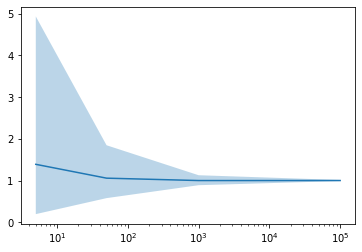

In [4]:
import matplotlib.pyplot as plt

out_iid = jnp.array(out)

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_iid, 0.025, axis=1), 
                 jnp.quantile(out_iid, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_iid, axis=1))
plt.xscale("log")
plt.yscale("log")

plt.savefig("images/ratio_iid.pdf")

In [ ]:
out_iid = jnp.array(out)

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_iid, 0.025, axis=1), 
                 jnp.quantile(out_iid, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_iid, axis=1))
plt.xscale("log")

plt.savefig("images/ratio_iid_exp.pdf")

In [5]:
def simulate_mgp(h, key):
    key, subkey = random.split(key)
    tmp = random.gamma(subkey, 2, shape=(nrep, 2, h-1))
    key, subkey = random.split(key)
    last_col = random.gamma(subkey, 1, shape=(nrep, 2, 1)) 
    tmp = jnp.concatenate([tmp, last_col], axis=-1)
    out = 1.0 / jnp.cumprod(tmp, axis=1)
    return out, key

In [6]:
nrep = 1000
out = []

for h in [5, 50, 1000, 100000]:
    key, subkey = random.split(key)
    m = random.gamma(subkey, 1, shape=(nrep, h))
    lambdas, key = simulate_mgp(h, key)
    num = vmap(jnp.dot)(lambdas[:, 0, :], m)
    den = vmap(jnp.dot)(lambdas[:, 1, :], m)
    out.append(num/den)

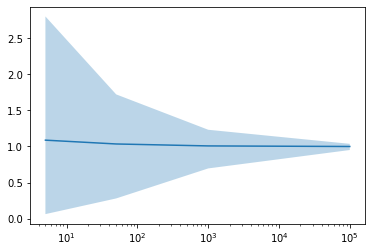

In [7]:
out_mgp = jnp.log(jnp.array(out))

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_mgp, 0.025, axis=1), 
                 jnp.quantile(out_mgp, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_mgp, axis=1))
plt.xscale("log")

plt.savefig("images/ratio_mgp.pdf")

In [ ]:
out_mgp = jnp.array(out)

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_mgp, 0.025, axis=1), 
                 jnp.quantile(out_mgp, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_mgp, axis=1))
plt.xscale("log")

plt.savefig("images/ratio_mgp_exp.pdf")

In [8]:
from jax.scipy.stats import gamma

def simulate_cusp(h, key):
    key, subkey = random.split(key)
    vs = random.beta(key, 1, 2, shape=(nrep, 2, h))
    cumprods = jnp.concatenate([
        jnp.ones(shape=(nrep, 2, 1)), 
        jnp.cumprod(1 - vs[:, :, :-1], axis=-1)], axis=-1)
    omegas = vs * cumprods
    pis = jnp.cumsum(omegas, axis=-1)
    
    key, subkey = random.split(key)
    berns = random.bernoulli(key, p=pis)
    
    key, subkey = random.split(key)
    inv_gams = 1.0 / random.gamma(key, 1.0, shape=(nrep, 2, h))
    
    out = (1-berns) * inv_gams + berns * 0.001
    
    return out, key

In [15]:
nrep = 1000
out = []

for h in [5, 50, 1000, 100000]:
    key, subkey = random.split(key)
    m = random.gamma(subkey, 1, shape=(nrep, h))
    lambdas, key = simulate_cusp(h, key)
    num = vmap(jnp.dot)(lambdas[:, 0, :], m)
    den = vmap(jnp.dot)(lambdas[:, 1, :], m)
    out.append(num / den)

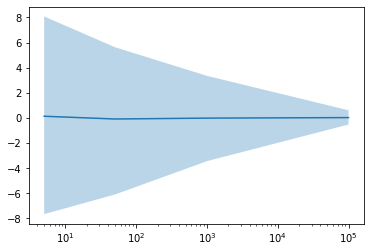

In [18]:
out_cusp = jnp.log(jnp.array(out))

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_cusp, 0.025, axis=1), 
                 jnp.quantile(out_cusp, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_cusp, axis=1))
plt.xscale("log")
plt.savefig("images/ratio_cusp.pdf")

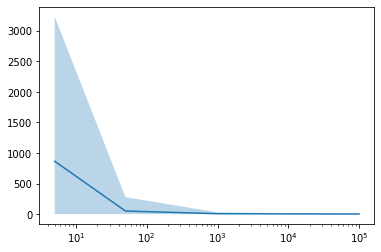

In [19]:
out_cusp = jnp.array(out)

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_cusp, 0.025, axis=1), 
                 jnp.quantile(out_cusp, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_cusp, axis=1))
plt.xscale("log")
plt.savefig("images/ratio_cusp_exp.pdf")

# As a function of the variance of $\Lambda$

In [26]:
nrep = 1000
out = []

h = 10

var = [0.5, 1.0, 2.0, 5.0]
for v in var:
    scale = v
    shape = 1.0 / v
    print(shape, scale)
    

    key, subkey = random.split(key)
    m = random.gamma(subkey, 1, shape=(nrep, h))
    
    key, subkey = random.split(key)
    lambdas = scale * random.gamma(subkey, shape, shape=(nrep, 2, h))
    
    num = vmap(jnp.dot)(lambdas[:, 0, :], m)
    den = vmap(jnp.dot)(lambdas[:, 1, :], m)
    
    out.append(num/den)

2.0 0.5
1.0 1.0
0.5 2.0
0.2 5.0


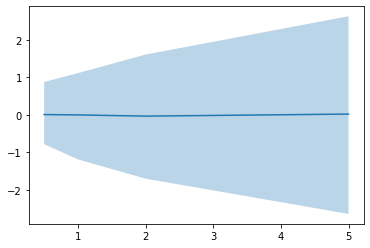

In [27]:
out_var = jnp.log(jnp.array(out))

plt.fill_between(var, 
                 jnp.quantile(out_var, 0.025, axis=1), 
                 jnp.quantile(out_var, 0.975, axis=1), alpha=0.3)
plt.plot(var, jnp.mean(out_var, axis=1))
plt.savefig("images/ratio_variance.pdf")

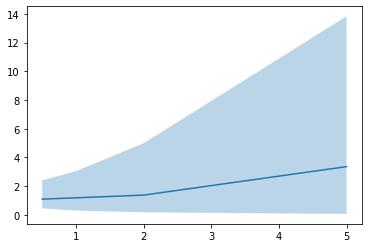

In [28]:
out_var = jnp.array(out)

plt.fill_between(var, 
                 jnp.quantile(out_var, 0.025, axis=1), 
                 jnp.quantile(out_var, 0.975, axis=1), alpha=0.3)
plt.plot(var, jnp.mean(out_var, axis=1))
plt.savefig("images/ratio_variance_exp.pdf")